# Neural Generalized Standard Material for viscoelasticity

In this demo, we implement a Generalized Standard Material (GSM) model of viscoelasticity, in which part of the model is represented by a neural network. This approach follows the general idea proposed by {cite:p}`flaschel2025convex`, where neural convex potentials are embedded in thermodynamically consistent constitutive models.

The goal is to demonstrate how a data-driven, physics-constrained constitutive model can be trained to reproduce a reference viscoelastic response generated by a classical model, while keeping full consistency with the framework of generalized standard materials.

```{admonition} Objectives
:class: important

This demo shows:

* How to define a hybrid neural constitutive model following the GSM structure
* How to generate synthetic viscoelastic data using a Generalized Maxwell model
* How to train a neural dissipation potential while keeping a known free energy
* How the number of internal variables affects the model’s ability to reproduce the true relaxation behavior
```

To simplify the exposition, we focus exclusively on a viscoelastic material.
The reference (“ground truth”) data is produced using a Generalized Maxwell model with 6 branches, with randomly generated viscoelastic properties. 

The training objective is to identify a neural GSM model with a reduced number of internal state variables, denoted $N_\text{var}$, while retaining the correct stress relaxation behavior. of internal state variables. The long-term elastic response is assumed to be known.

## Theoretical background

### Generalized Standard Materials

A generalized standard material {cite:p}`halphen1975materiaux` is defined by a free energy potential $\Psi(\beps,\balpha)$ and a dissipation potential $\Phi(\dot\balpha)$, from which all constitutive relations are derived in a thermodynamically consistent way. The internal state variable evolution over a time-step is obtained by minimizing a so-called *incremental potential* {cite:p}`ortiz1999variational`:

$$\min_{\Delta \balpha} J(\Delta\balpha ;\beps_{n+1},\balpha_n) = \min_{\Delta \balpha} \Psi(\beps_{n+1}, \balpha_n + \Delta \balpha)
    + \Delta t \Phi\left(\dfrac{\Delta \balpha}{\Delta t}\right)$$

subject to the current strain $\beps_{n+1} = \beps_n+\Delta\beps$ and time increment $\Delta t$.

### Hybrid neural GSM architecture

Here we consider a hybrid architecture inspired by the Generalized Maxwell model, in which:
- $N_\text{var}$ represents the number of viscous branches
- each branch has a linear elastic spring with stiffness $\CC_i$
- the viscous effects are governed by a neural dissipation potential represented by an Input Convex Neural Network (ICNN) {cite:p}`amos2017icnn`.

The constitutive potentials are written as:
- free energy:

$$
\Psi(\beps,\balpha_i) = \dfrac{1}{2}\beps:\CC_0:\beps + \sum_{i=1}^{N_\text{var}}\dfrac{1}{2}(\beps-\balpha_i):\CC_i:(\beps-\balpha_i)
$$

- dissipation potential:

$$
\Phi(\dot{\balpha}_i) = \mathcal{N}_\text{ICNN}(\dot{\balpha}_1,\ldots,\dot{\balpha}_{N_\textrm{var}})
$$

Unlike the classical Maxwell model where each branch dissipates independently, the neural potential couples all internal variables through a single convex function $\Phi$. This allows for nonlinear and non-separable viscous interactions while ensuring that the model remains thermodynamically admissible.

```{note}
The ground truth generalized Maxwell model with $N$ branches would be represented by the following potentials where the $\balpha_i$ represent the viscous strains $\beps^\text{v}_i$ in each branch:
- free energy:

$$
\Psi(\beps,\beps_i^\text{v}) = \dfrac{1}{2}\beps:\CC_0:\beps + \sum_{i=1}^{N}\dfrac{1}{2}(\beps-\beps_i^\text{v}):\CC_i:(\beps-\beps_i^\text{v})
$$

- dissipation potential:

$$
\Phi(\dot{\beps}_i^\text{v}) = \sum_{i=1}^N \dfrac{1}{2}\eta_i \dot{\beps}_i^\text{v}:\dot{\beps}_i^\text{v}
$$
```

## Ground-truth data generation

We first define the ground truth data from a generalized Maxwell model with `Nmax=6` branches. The viscous elements are generated so that their relaxation times are spaced within the interval $0.005\text{ s}$--$10\text{ s}$ with random stiffness values. The synthetic stress–strain data obtained from this model will serve as our training target.

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

import equinox as eqx
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jaxmat.state import make_batched, AbstractState
from jaxmat.utils import partition_by_node_names
from jaxmat.tensors import SymmetricTensor2, main_invariants, eigenvalues
from jaxmat.nn.icnn import ICNN, ICNNSkip
import jaxmat.materials as jm
import optimistix as optx
import optax

E0, nu = 70e3, 0.3
elastic_model = jm.LinearElasticIsotropic(E0, nu)

key = jax.random.PRNGKey(42)
key1, key2, key3 = jax.random.split(key, num=3)

tau = jnp.asarray([0.005, 0.1, 0.05, 0.2, 2, 10])
E1 = jax.random.lognormal(key1, shape=(len(tau),))*10e3
viscous_model = jm.LinearElasticIsotropic(E1, jnp.full_like(E1, fill_value=nu))

material = jm.GeneralizedMaxwell(
    elasticity=elastic_model,
    viscous_branches=viscous_model,
    relaxation_times=tau,
)

To train the model, we consider a stress relaxation (recovery) test under constant shear strain: $\epsilon_{xy}=\gamma_r/2$ with $\gamma_r=10^{-3}$ applied over a time interval  $10^{-3}--10^2\text{ s}$. The time discretization is logarithmic to capture both the fast initial relaxation and the slower long-term response.

In [2]:
Nincr = 50
times = jnp.logspace(-3, 2, Nincr + 1)
gamma_r = 1e-3
gamma = jnp.full_like(jnp.diff(times), fill_value=gamma_r)

We define a general-purpose function `compute_evolution` that integrates the constitutive equations over time for a given strain path.
Starting from the initial state, the model is updated incrementally at each time step using the internal solver provided by `jaxmat` and returns the full stress history. By using `jax.lax.scan`, the loop over time increments is efficiently compiled by JAX, ensuring high performance and differentiability.

In [3]:
def compute_evolution(material, gamma_list, times):
    # Initial material state
    state0 = material.init_state()
    dt = jnp.diff(times)

    def step(state, args):
        gamma, dt_ = args
        # Build symmetric strain tensor
        new_eps = jnp.array([[0, gamma / 2, 0], [gamma / 2, 0, 0], [0, 0, 0]])

        # Create tensor object (assuming this is JAX-compatible)
        new_eps = SymmetricTensor2(tensor=new_eps)

        # Update material response
        new_stress, new_state = material.constitutive_update(new_eps, state, dt_)

        return new_state, new_stress

    # Use lax.scan to loop over gamma_list efficiently
    _, sig = jax.lax.scan(step, state0, (gamma_list, dt))

    return sig

## Defining the neural GSM

The GSM model is composed of three parts:

- Free energy potential, defines the recoverable elastic energy stored in both the equilibrium and viscous branches.
- Dissipation potential, modeled by an Input Convex Neural Network (ICNN) to ensure convexity with respect to strain rates.
- Internal state variables, representing the viscous strain tensors $\balpha_i$.

We first define the internal state PyTree as a batch of symmetric strain tensors $\balpha_i$ representing the $N_\text{var}$ viscous strains in each Maxwell-like branch.

In [4]:
class InternalState(AbstractState):
    alpha: SymmetricTensor2 = eqx.field(init=False)
    """Viscoelastic strains."""
    Nvar: int = eqx.field(static=True, default=1)
    """Number of viscoelastic variables."""

    def __post_init__(self):
        self.alpha = make_batched(SymmetricTensor2(), self.Nvar)

The free energy is implemented as a sum of quadratic elastic contributions in the form of an `equinox.Module`. The free energy `__call__` function takes as arguments the total strain $\beps$ (`eps`) and the PyTree (`isv`) of internal state variables $(\balpha_i)$.

In [5]:
class FreeEnergy(eqx.Module):
    elastic_model: jm.AbstractLinearElastic
    viscous_model: list[jm.AbstractLinearElastic]

    def __call__(self, eps, isv):

        alpha = isv.alpha
        psi_el = 0.5 * jnp.trace(eps @ (self.elastic_model.C @ eps))

        def viscous_free_energy(viscous_model, alpha):
            eps_el = eps - alpha
            return 0.5 * jnp.trace(eps_el @ (viscous_model.C @ eps_el))

        psi_v = jnp.sum(jax.vmap(viscous_free_energy)(self.viscous_model, alpha))
        return psi_el + psi_v

The dissipation potential is represented by an Input-Convex Neural Network (ICNN) which guarantees convexity through positive weights and nonnegative increasing activation functions.

Inspired by the Physics-Augmented Neural networks (PANN) approach for elasticity, we choose here as inputs of the network the second invariants $I_2(\balpha_i)$ of the state variables. We also add a normalization term so that the thermodynamic force is zero for $\balpha_i=0$, modifying the potential as follows:

$$
\Phi(\balpha_i) = \Nn_\text{ICNN}(\balpha_i) - \dfrac{\partial \Nn_\text{ICNN}}{\partial\balpha_i}(\balpha_i=0):\balpha_i
$$

In [6]:
class ICNNDissipationPotential(ICNN):
    def icnn_potential(self, alpha_dot):
        I1, I2, I3 = jax.vmap(main_invariants)(alpha_dot)
        return super().__call__(1e3*I2)
       
    def __call__(self, isv_dot):
        alpha_dot = isv_dot.alpha.tensor
        return (
            self.icnn_potential(alpha_dot)
            - jax.jvp(self.icnn_potential, (jnp.zeros_like(alpha_dot),), (alpha_dot,))[1]
        )

We build a list of candidate neural GSM models for  $N_\text{var}=1,2,3$. Each model shares the same known long-term stiffness, while the viscous stiffness values and neural potential parameters are initialized randomly. We select here only 8 neurons in a single hidden layer.

The idea is to assess how the complexity of the internal structure (i.e., the number of internal variables) affects the ability of the neural GSM to reproduce the reference relaxation behavior.

In [7]:
Nvar_list = [1, 2, 3]
gsm_list = []
for Nvar in Nvar_list:
    hidden_dims = [8]
    icnn_dissipation_potential = ICNNDissipationPotential(Nvar, hidden_dims, key3)
    E1_ = jax.random.lognormal(key2, shape=(Nvar,)) * 1e3
    viscous_model = jm.LinearElasticIsotropic(E1_, jnp.full_like(E1_, fill_value=nu))
    free_energy = FreeEnergy(elastic_model=elastic_model, viscous_model=viscous_model)
    internal_state = InternalState(Nvar=Nvar)
    gsm_list.append(
        jm.GeneralizedStandardMaterial(
            free_energy=free_energy,
            dissipation_potential=icnn_dissipation_potential,
            internal=internal_state,
        )
    )

## Training procedure

### Initialization

Before training, we compute the ground truth response under the prescribed strain history obtained from the 6-branch Generalized Maxwell model. We generate synthetic white noise to this data. Finally, we compute the predicted stress response of the randomly initialized neural GSM (for $N_\text{var}=3$) and compare it with the ground truth and noisy data.

At this stage, the predicted stress does not match the target relaxation curve — the neural model’s dissipation potential is untrained and cannot yet capture the correct time-dependent decay.

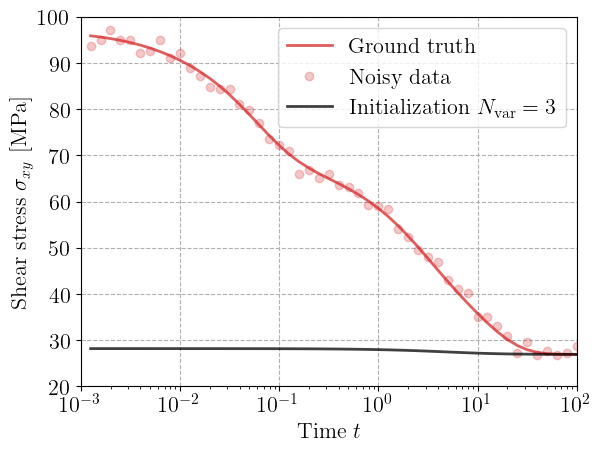

In [8]:
sig_train = compute_evolution(material, gamma, times)
sig_noise = SymmetricTensor2(tensor=sig_train.tensor + jax.random.normal(key, shape=sig_train.tensor.shape))
sig_init = compute_evolution(gsm_list[-1], gamma, times)

plt.figure()
plt.semilogx(times[1:], sig_train[:, 0, 1], "-C3", alpha=0.75, label="Ground truth")
plt.semilogx(times[1:], sig_noise[:, 0, 1], "oC3", alpha=0.25, label="Noisy data")
plt.semilogx(
    times[1:],
    sig_init[:, 0, 1],
    "-k",
    alpha=0.75,
    label=rf"Initialization $N_\textrm{{var}}={Nvar}$",
)
plt.xlabel("Time $t$")
plt.ylabel(r"Shear stress $\sigma_{xy}$ [MPa]")
plt.legend()
plt.show()

### Loss function

The training process aims to minimize the discrepancy between the predicted and target stress histories.
We use the mean-squared error (MSE) loss function on the whole stress tensors:

$$
\mathcal{L}(\btheta) = \dfrac{1}{M}\sum_{k=1}^M \|\hat\bsig^{(k)}(\btheta) - \bsig^\text{data,(k)}\|^2
$$
where $\hat\bsig^{(k)}(\btheta)$ denotes the predicted stress tensor by the neural GSM at time step $k$ and $ \bsig^\text{data,(k)}$ the corresponding target value.
As the stress evolution depends recursively on the internal variables, the loss is history-dependent.
Gradients are automatically computed by JAX through the full time integration and solver iterations.

In [9]:
@eqx.filter_jit
def loss(trainable, args):
    sig_data, static = args
    if static is None:
        material_ = trainable
    else:
        material_ = eqx.combine(trainable, static)
    sig_hat = compute_evolution(material_, gamma, times)
    loss_ = optax.l2_loss(sig_hat.array.flatten(), sig_data.array.flatten())
    return (
        loss_.mean(),
        sig_hat,
    )

### Optimization strategy

We employ an `optax` optimizer based on Adam with parameter-block RMS normalization, which rescales gradients according to their variance across model parameters.
This helps stabilize training in the presence of quantities with different physical magnitudes.

The optimization is wrapped in an `optimistix.OptaxMinimiser`, which provides a clean interface for running the differentiable solver loop.

In [10]:
learning_rate = 5e-2
optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_param_block_rms(),
    optax.scale(-learning_rate),
)

max_steps = 1000
solver = optx.OptaxMinimiser(
    optimizer,
    rtol=1e-6,
    atol=1e-6,
    # verbose=frozenset({"loss", "step_size"}),
)

### Results

Each neural GSM is trained independently against the same noisy reference data.

During training, the equilibrium elastic model is kept frozen (not trainable), the viscous stiffness values and ICNN parameters are updated to minimize the loss.

The backward-mode automatic differentiation (`jac="bwd"`) option is used for efficiency, as we are minimizing a scalar loss function.
At the end of training, the trained parameters are combined with the static part to reconstruct the full model.

For each value of $N_\text{var}$, we plot the predicted relaxation curve against the ground truth data.

The model with a single viscoelastic strain fails in reproducing the whole relaxation curve, despite being able to represent more than a single relaxation term since the viscosity dissipation potentially is not necessarily quadratic.
Increasing $N_\text{var}$ to 2 and 3 clearly improves the results. The trained neural GSM reproduces the full multi-timescale relaxation curve almost perfectly.

This demonstrates that the neural GSM can efficiently compress the complex 6-branch Maxwell response into a reduced number of internal variables, while maintaining full thermodynamic consistency.

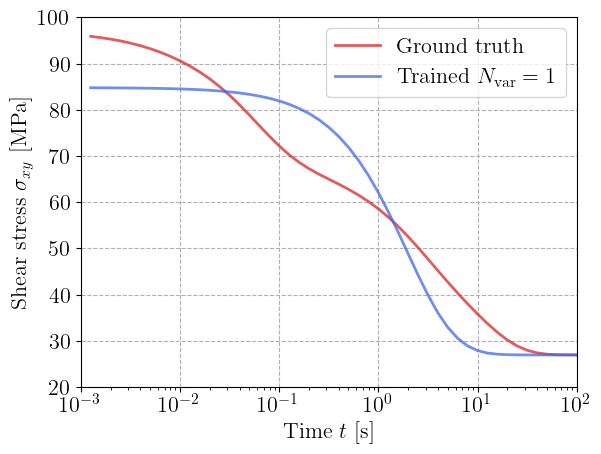

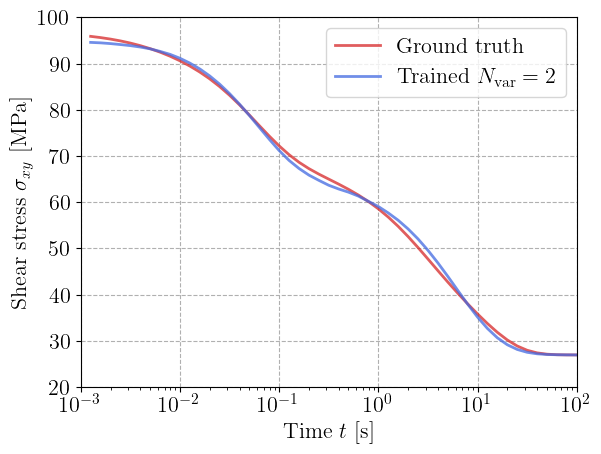

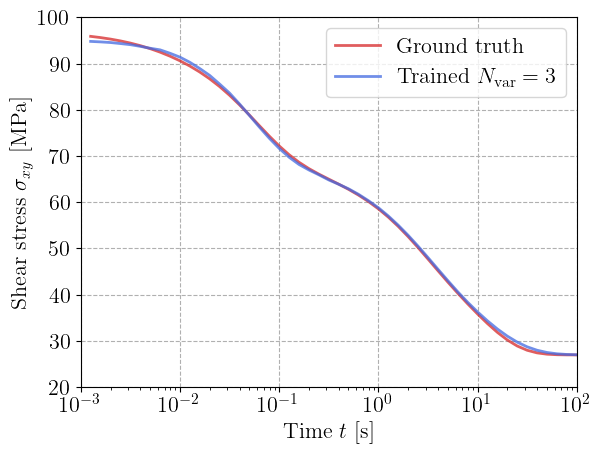

In [11]:
for gsm, Nvar in zip(gsm_list, Nvar_list):

    trainable, static = partition_by_node_names(gsm, ["free_energy.elastic_model"])

    sol = optx.minimise(
        loss,
        solver,
        trainable,
        args=(sig_noise, static),
        has_aux=True,
        throw=False,
        max_steps=max_steps,
        options={"jac": "bwd"},
    )
    trained_params = sol.value
    if static is None:
        trained_material = trained_params
    else:
        trained_material = eqx.combine(trained_params, static)
    sig_hat = sol.aux

    plt.figure()
    plt.semilogx(times[1:], sig_train[:, 0, 1], "-C3", alpha=0.75, label="Ground truth")
    plt.semilogx(
        times[1:],
        sig_hat[:, 0, 1],
        "-",
        color="royalblue",
        alpha=0.75,
        label=rf"Trained $N_\textrm{{var}}={Nvar}$",
    )
    plt.xlabel("Time $t$ [s]")
    plt.ylabel(r"Shear stress $\sigma_{xy}$ [MPa]")
    plt.legend()
    plt.show()

## Comparison with a reduced generalized Maxwell model

Finally, we can train in a very similar fashion a generalized Maxwell model with a reduced number of branches. Below, we show how to do it by fixing the values for the relaxation times and learning only the viscous branches stiffness values.

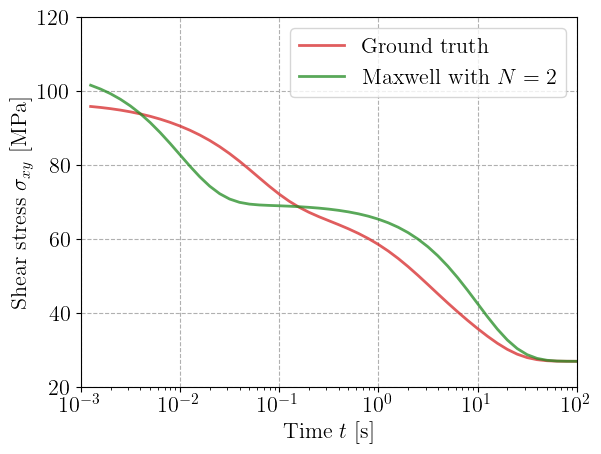

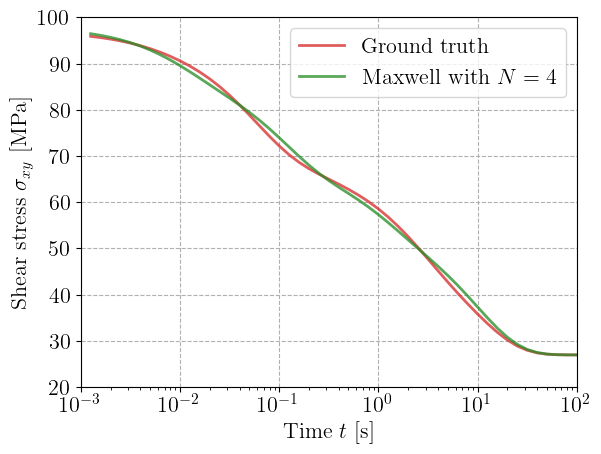

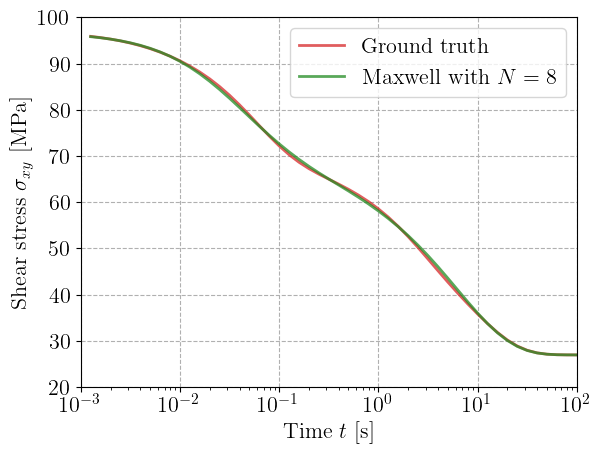

In [12]:
maxwell_list = []
Nmax_list = [2, 4, 8]
for Nmax in Nmax_list:
    E1_ = jax.random.lognormal(key2, shape=(Nmax,)) * 1e3
    tau_ = jnp.logspace(-2, 1, Nmax)
    viscous_model = jm.LinearElasticIsotropic(E1_, jnp.full_like(E1_, fill_value=nu))
    maxwell_list.append(jm.GeneralizedMaxwell(elasticity=elastic_model, viscous_branches=viscous_model, relaxation_times=tau_))

for maxwell, Nmax in zip(maxwell_list, Nmax_list):

    trainable, static = partition_by_node_names(maxwell, ["elasticity", "relaxation_times"])

    sol = optx.minimise(
        loss,
        solver,
        trainable,
        args=(sig_noise, static),
        has_aux=True,
        throw=False,
        max_steps=max_steps,
        options={"jac": "bwd"},
    )
    trained_params = sol.value
    if static is None:
        trained_material = trained_params
    else:
        trained_material = eqx.combine(trained_params, static)
    sig_hat = sol.aux

    plt.figure()
    plt.semilogx(times[1:], sig_train[:, 0, 1], "-C3", alpha=0.75, label="Ground truth")
    plt.semilogx(
        times[1:],
        sig_hat[:, 0, 1],
        "-",
        color="forestgreen",
        alpha=0.75,
        label=rf"Maxwell with $N={Nmax}$",
    )
    plt.xlabel("Time $t$ [s]")
    plt.ylabel(r"Shear stress $\sigma_{xy}$ [MPa]")
    plt.legend()
    plt.show()

## References

```{bibliography}
:filter: docname in docnames
```